In [1]:
import sim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Connected
Simulation time in milliseconds:  10800
Omnirob is at [x,y,z]= [7.624996185302734, 8.549081802368164, 0.3544994294643402]
Disconnected


In [3]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

In [4]:
def point_to_point_traj(x1, x2, v1, v2, delta_t):
    t = np.linspace(0, delta_t, 100)  
    a0 = x1
    a1 = v1
    a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
    a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

    polynomial = a0 + a1 * t + a2 * t**2 + a3 * t**3
    derivative = a1 + 2*a2 * t + 3 * a3 * t**2
    print('a0: (%.4f) '%(a0))
    print('a1: (%.4f) '%(a1))
    print('a2: (%.4f) '%(a2))
    print('a3: (%.4f) '%(a3))
    return polynomial, derivative

def a_pairs(x1, x2, v1, v2, delta_t):
    t = np.linspace(0, delta_t, 100)  
    a0 = x1
    a1 = v1
    a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
    a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

    #print('a0: (%.4f) '%(a0))
    #print('a1: (%.4f) '%(a1))
    #print('a2: (%.4f) '%(a2))
    #print('a3: (%.4f) '%(a3))
    return a0, a1, a2, a3

def piecewise2D (X,Y, Vx, Vy, T):
    theta_x, theta_y, dx, dy = [], [], [], []
    a0_pairs = []
    a1_pairs = []
    a2_pairs = []
    a3_pairs = []

    
    count = 1
    for i in range(len(P)-1):
        print(count)
        count = count+1
        print('x')
        theta_xi, dxi = point_to_point_traj(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        xa0, xa1, xa2, xa3 = a_pairs(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        print('y')
        theta_yi, dyi = point_to_point_traj(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])
        ya0, ya1, ya2, ya3 = a_pairs(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])
        print('=================')
        
        a0_pairs.append([xa0, ya0])
        a1_pairs.append([xa1, ya1])
        a2_pairs.append([xa2, ya2])
        a3_pairs.append([xa3, ya3])
        
        theta_x += theta_xi.tolist()
        theta_y += theta_yi.tolist()
        dx += dxi.tolist()
        dy += dyi.tolist()

        plot(theta_xi, theta_yi)
    return theta_x, theta_y, dx, dy, a0_pairs, a1_pairs, a2_pairs, a3_pairs

# Plotting
def plot_points():
    plot(X,Y, '--')
    plot(X,Y, 'o')
    quiver(X,Y, Vx, Vy, color='r')

def plot_points_3d():
    plot(X,Y,Z, '--')
    plot(X,Y,Z, 'o')
    
# Speed
def plot_speed():
    speed = np.sqrt(np.array(dx)**2 + np.array(dy)**2)
    plot(speed)

[[0, 0], [-0.125, -0.125], [-0.125, -0.125], [-0.125, -0.125], [0.0, -0.125], [0.0, -0.125], [-0.125, -0.125], [-0.125, 0.0], [-0.125, -0.125], [-0.125, -0.125], [-0.125, 0.0], [-0.125, 0.0], [-0.125, 0.0], [-0.125, -0.125], [0.0, -0.125], [-0.125, -0.125], [-0.125, -0.125], [-0.125, -0.125], [-0.125, -0.125], [0.0, -0.125], [0.0, -0.125], [0.125, -0.125]]
1
x
a0: (6.5000) 
a1: (0.0000) 
a2: (-0.0175) 
a3: (0.0008) 
y
a0: (8.5000) 
a1: (0.0000) 
a2: (-0.0175) 
a3: (0.0008) 
2
x
a0: (5.5000) 
a1: (-0.1250) 
a2: (0.0075) 
a3: (-0.0005) 
y
a0: (7.5000) 
a1: (-0.1250) 
a2: (0.0075) 
a3: (-0.0005) 
3
x
a0: (4.5000) 
a1: (-0.1250) 
a2: (0.0075) 
a3: (-0.0005) 
y
a0: (6.5000) 
a1: (-0.1250) 
a2: (0.0075) 
a3: (-0.0005) 
4
x
a0: (3.5000) 
a1: (-0.1250) 
a2: (0.0250) 
a3: (-0.0013) 
y
a0: (5.5000) 
a1: (-0.1250) 
a2: (0.0075) 
a3: (-0.0005) 
5
x
a0: (3.5000) 
a1: (0.0000) 
a2: (0.0000) 
a3: (0.0000) 
y
a0: (4.5000) 
a1: (-0.1250) 
a2: (0.0075) 
a3: (-0.0005) 
6
x
a0: (3.5000) 
a1: (0.0000) 
a2:

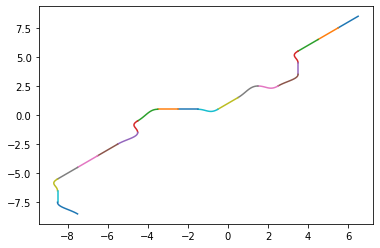

In [5]:
##Calculate Trajectories
##### Requirements for the trajectory
#c_path calculated: 
c_path = [(6.5, 8.5), (5.5, 7.5), (4.5, 6.5), (3.5, 5.5), (3.5, 4.5), (3.5, 3.5), (2.5, 2.5), (1.5, 2.5), (0.5, 1.5), (-0.5, 0.5), (-1.5, 0.5), (-2.5, 0.5), (-3.5, 0.5), (-4.5, -0.5), (-4.5, -1.5), (-5.5, -2.5), (-6.5, -3.5), (-7.5, -4.5), (-8.5, -5.5), (-8.5, -6.5), (-8.5, -7.5), (-7.5, -8.5)]

# Velocities
vs = [[0,0]]
for c_index in range(0,len(c_path)-1):
    rn = c_path[c_index]
    fut = c_path[c_index+1]
    xs = fut[0]-rn[0]
    ys = fut[1]-rn[1]
    if xs != 0:
        xs = xs/8
    if ys != 0:
        ys = ys/8
    vs.append([xs,ys])
print(vs)
    
# Time
ts = []
for tim in range(0,len(c_path)):
    ts.append(tim*10)

# Grouping
#P = np.vstack((p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, p17))
#V = np.vstack((v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15, v16, v17))
#T = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12, t13, t14, t15, t16, t17]
P = np.vstack(c_path)
V = np.vstack(vs)
T = ts
X, Y = P[:,0], P[:,1]
Vx, Vy = V[:,0], V[:,1]

# Plotting
#plot_points()
#show()

# Piecewise function
theta_x, theta_y, dx, dy, a0_pairs, a1_pairs, a2_pairs, a3_pairs = piecewise2D(X,Y, Vx,Vy, T)

In [6]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

# Initial locations
robot_position = r.get_position()
print('Robot position: (%.2f, %.2f) '%(robot_position[0], robot_position[1]))

# Virtual disk
disk = robot('Disc', client_id=r.client_id)

# Time duration
tf = 10
# Time interval
time_steps = linspace(0, tf, 100)

count = 0
for wp in T:  
    print("Count: ",count)
    a0 = a0_pairs[count]
    a1 = a1_pairs[count]
    a2 = a2_pairs[count]
    a3 = a3_pairs[count]
    print('a0: %s'%(a0))
    print('a1: %s'%(a1))
    print('a2: %s'%(a2))
    print('a3: %s'%(a3))

    for t in time_steps:
        # Compute trajectory
        x_point_traj = a0[0] + a1[0]*t + a2[0]*(t**2) + a3[0]*(t**3) #Gamma_x
        x_vel_traj = a1[0] + 2*a2[0]*t + 3*a3[0]*(t**2) #Derivative of Gamma_x
        y_point_traj = a0[1] + a1[1]*t + a2[1]*(t**2) + a3[1]*(t**3) #Gamma_y
        y_vel_traj = a1[1] + 2*a2[1]*t + 3*a3[1]*(t**2) #Derivative of Gamma_y
        #print('(%.4f,%.4f)' %(x_point_traj, y_point_traj))

        disk.set_position([x_point_traj, y_point_traj])

        # Sensing
        robot_position = r.get_position()

        # Trajectory tracker
        u = 10 * (np.array([x_point_traj, y_point_traj, 0]) - robot_position) + np.array([x_vel_traj, y_vel_traj, 0])

        vx, vy, vz = u
        r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])

        time.sleep(tf/2000)
    
    count+=1

    r.send_motor_velocities([0,0,0,0])
r.close_connection()

Robot connected
Robot position: (7.62, 8.55) 
Robot connected
Count:  0
a0: [6.5, 8.5]
a1: [0.0, 0.0]
a2: [-0.0175, -0.0175]
a3: [0.00075, 0.00075]
Count:  1
a0: [5.5, 7.5]
a1: [-0.125, -0.125]
a2: [0.0075, 0.0075]
a3: [-0.0005, -0.0005]
Count:  2
a0: [4.5, 6.5]
a1: [-0.125, -0.125]
a2: [0.0075, 0.0075]
a3: [-0.0005, -0.0005]
Count:  3
a0: [3.5, 5.5]
a1: [-0.125, -0.125]
a2: [0.025, 0.0075]
a3: [-0.00125, -0.0005]
Count:  4
a0: [3.5, 4.5]
a1: [0.0, -0.125]
a2: [0.0, 0.0075]
a3: [0.0, -0.0005]
Count:  5
a0: [3.5, 3.5]
a1: [0.0, -0.125]
a2: [-0.0175, 0.0075]
a3: [0.00075, -0.0005]
Count:  6
a0: [2.5, 2.5]
a1: [-0.125, -0.125]
a2: [0.0075, 0.025]
a3: [-0.0005, -0.00125]
Count:  7
a0: [1.5, 2.5]
a1: [-0.125, 0.0]
a2: [0.0075, -0.0175]
a3: [-0.0005, 0.00075]
Count:  8
a0: [0.5, 1.5]
a1: [-0.125, -0.125]
a2: [0.0075, 0.0075]
a3: [-0.0005, -0.0005]
Count:  9
a0: [-0.5, 0.5]
a1: [-0.125, -0.125]
a2: [0.0075, 0.025]
a3: [-0.0005, -0.00125]
Count:  10
a0: [-1.5, 0.5]
a1: [-0.125, 0.0]
a2: [0.007

IndexError: list index out of range